In [1]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
from rasterio.enums import Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape as shp_shape
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# --- File Paths ---
PROJECT_DIR = r"C:\Users\salma\Desktop\project"
SAFE_DIR = os.path.join(PROJECT_DIR, "S2B_MSIL2A_20250306T042709_N0511_R133_T46RCP_20250306T062707.SAFE")
KAMRUP_SHP = os.path.join(PROJECT_DIR, "KAMRUP.shp")
OSM_BUILDINGS = os.path.join(PROJECT_DIR, "guwahati_osm_buildings.geojson")

# --- Load shapefiles ---
kamrup = gpd.read_file(KAMRUP_SHP).to_crs(epsg=32646)
osm_buildings = gpd.read_file(OSM_BUILDINGS).to_crs(kamrup.crs)

# --- Helper to get Sentinel-2 band path ---
def get_band_path(band, res="10m"):
    for root, _, files in os.walk(SAFE_DIR):
        for f in files:
            if f.endswith(f"{band}_{res}.jp2"):
                return os.path.join(root, f)

# --- Load and clip 10m bands ---
band_keys = ["B02", "B03", "B04", "B08"]
bands = {}
for band in band_keys:
    with rasterio.open(get_band_path(band)) as src:
        clipped, transform = mask(src, kamrup.geometry, crop=True)
        bands[band] = clipped[0]
        meta = src.meta

# --- Update metadata ---
meta.update({
    "height": bands["B02"].shape[0],
    "width": bands["B02"].shape[1],
    "transform": transform,
    "count": 1
})

# --- Add NDBI (requires B11 resampled to 10m) ---
with rasterio.open(get_band_path("B11", res="20m")) as src_b11:
    b11_resampled = src_b11.read(
        out_shape=(1, bands["B08"].shape[0], bands["B08"].shape[1]),
        resampling=Resampling.bilinear
    )[0]

ndbi = (b11_resampled - bands["B08"]) / (b11_resampled + bands["B08"] + 1e-10)

# --- Stack bands + NDBI ---
stacked_bands = np.stack([bands["B02"], bands["B03"], bands["B04"], bands["B08"], ndbi], axis=-1)

# --- Flatten for classification ---
n_pixels = stacked_bands.shape[0] * stacked_bands.shape[1]
X = stacked_bands.reshape((n_pixels, 5))

In [2]:
# --- Create building mask from OSM ---
from rasterio.features import rasterize
osm_mask = rasterize(
    [(geom, 1) for geom in osm_buildings.geometry],
    out_shape=(stacked_bands.shape[0], stacked_bands.shape[1]),
    transform=transform,
    fill=0,
    dtype='uint8'
)
y = osm_mask.flatten()

# --- Balance classes (optional) ---
building_pixels = np.where(y == 1)[0]
non_building_pixels = np.where(y == 0)[0]
np.random.seed(42)
non_building_sample = np.random.choice(non_building_pixels, size=len(building_pixels), replace=False)
balanced_indices = np.concatenate([building_pixels, non_building_sample])
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

# --- Standardize the features for better SVM performance ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# --- Train SVM with RBF kernel ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.3, random_state=42)

# Initialize the SVM classifier with RBF kernel
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale')  # You can tune these hyperparameters
svm_clf.fit(X_train, y_train)

# --- Evaluate the model ---
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      1193
           1       0.80      0.97      0.88      1182

    accuracy                           0.87      2375
   macro avg       0.88      0.87      0.87      2375
weighted avg       0.88      0.87      0.87      2375



In [4]:
# Ensure you're predicting on the full set of features
n_pixels = stacked_bands.shape[0] * stacked_bands.shape[1]
X_full = stacked_bands.reshape((n_pixels, 5))  # Flattening the stacked bands
X_full_scaled = scaler.transform(X_full)  # Apply the same scaling as the training data


In [5]:
# Predict using the trained SVM model
y_all = svm_clf.predict(X_full_scaled)

# Ensure that the predicted labels match the size of the original raster image
predicted_image = y_all.reshape(stacked_bands.shape[0], stacked_bands.shape[1])

# --- Save raster output ---
with rasterio.open("building_classification_svm.tif", "w", **meta) as dst:
    dst.write(predicted_image.astype(rasterio.uint8), 1)


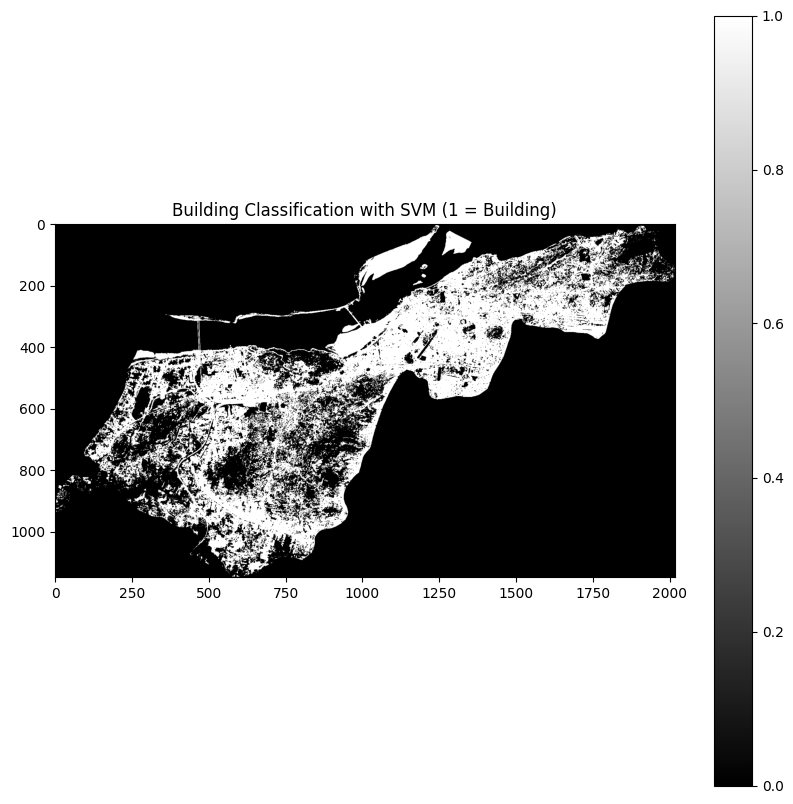

In [6]:
# --- Visualize result ---
plt.figure(figsize=(10, 10))
plt.imshow(predicted_image, cmap="gray")
plt.title("Building Classification with SVM (1 = Building)")
plt.colorbar()
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      1193
           1       0.80      0.97      0.88      1182

    accuracy                           0.87      2375
   macro avg       0.88      0.87      0.87      2375
weighted avg       0.88      0.87      0.87      2375



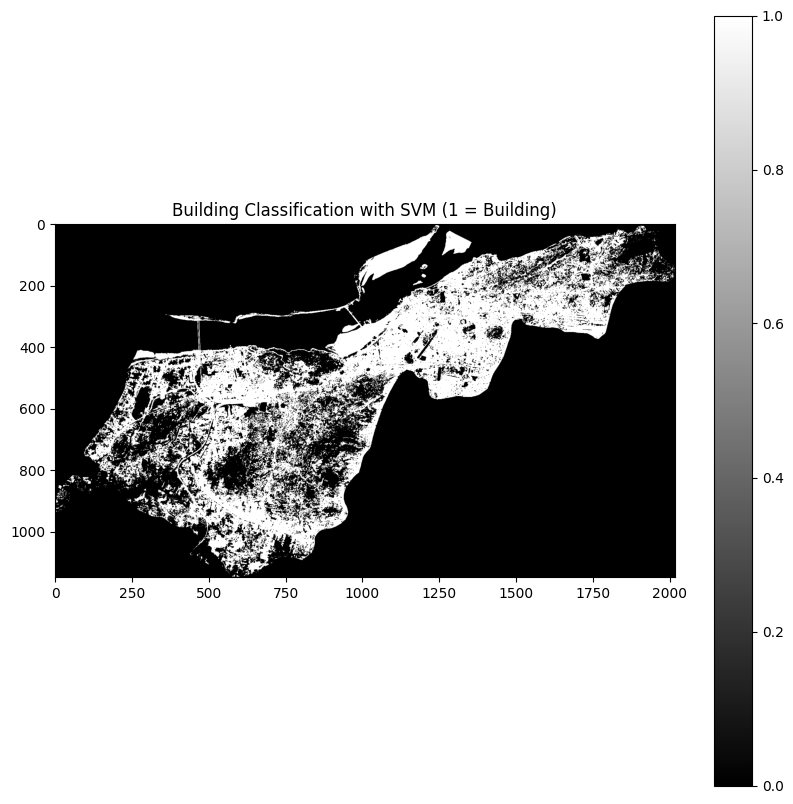

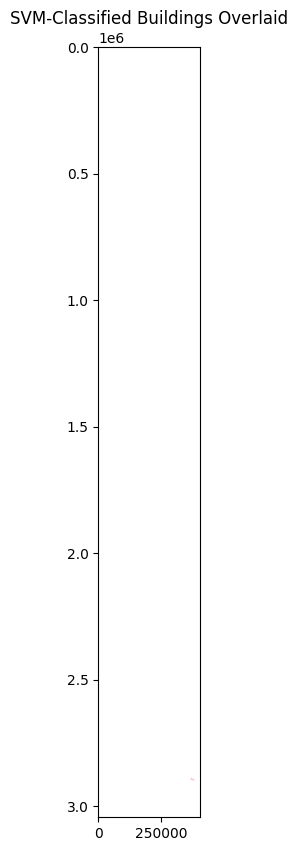

In [7]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.features import rasterize, shapes
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape as shp_shape
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# --- File Paths ---
PROJECT_DIR = r"C:\Users\salma\Desktop\project"
SAFE_DIR = os.path.join(PROJECT_DIR, "S2B_MSIL2A_20250306T042709_N0511_R133_T46RCP_20250306T062707.SAFE")
KAMRUP_SHP = os.path.join(PROJECT_DIR, "KAMRUP.shp")
OSM_BUILDINGS = os.path.join(PROJECT_DIR, "guwahati_osm_buildings.geojson")

# --- Load shapefiles ---
kamrup = gpd.read_file(KAMRUP_SHP).to_crs(epsg=32646)
osm_buildings = gpd.read_file(OSM_BUILDINGS).to_crs(kamrup.crs)

# --- Helper to get Sentinel-2 band path ---
def get_band_path(band, res="10m"):
    for root, _, files in os.walk(SAFE_DIR):
        for f in files:
            if f.endswith(f"{band}_{res}.jp2"):
                return os.path.join(root, f)

# --- Load and clip bands ---
band_keys = ["B02", "B03", "B04", "B08"]
bands = {}
for band in band_keys:
    with rasterio.open(get_band_path(band)) as src:
        clipped, transform = mask(src, kamrup.geometry, crop=True)
        bands[band] = clipped[0]
        meta = src.meta

# --- Update metadata ---
meta.update({
    "height": bands["B02"].shape[0],
    "width": bands["B02"].shape[1],
    "transform": transform,
    "count": 1
})

# --- Add NDBI (B11 resampled to 10m) ---
with rasterio.open(get_band_path("B11", res="20m")) as src_b11:
    b11_resampled = src_b11.read(
        out_shape=(1, bands["B08"].shape[0], bands["B08"].shape[1]),
        resampling=Resampling.bilinear
    )[0]
ndbi = (b11_resampled - bands["B08"]) / (b11_resampled + bands["B08"] + 1e-10)

# --- Stack bands + NDBI ---
stacked_bands = np.stack([bands["B02"], bands["B03"], bands["B04"], bands["B08"], ndbi], axis=-1)

# --- Flatten for classification ---
n_pixels = stacked_bands.shape[0] * stacked_bands.shape[1]
X_full = stacked_bands.reshape((n_pixels, 5))

# --- Create building mask from OSM ---
osm_mask = rasterize(
    [(geom, 1) for geom in osm_buildings.geometry],
    out_shape=(stacked_bands.shape[0], stacked_bands.shape[1]),
    transform=transform,
    fill=0,
    dtype='uint8'
)
y_full = osm_mask.flatten()

# --- Balance classes ---
building_pixels = np.where(y_full == 1)[0]
non_building_pixels = np.where(y_full == 0)[0]
np.random.seed(42)
non_building_sample = np.random.choice(non_building_pixels, size=len(building_pixels), replace=False)
balanced_indices = np.concatenate([building_pixels, non_building_sample])
X_balanced = X_full[balanced_indices]
y_balanced = y_full[balanced_indices]

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# --- Train SVM Classifier ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.3, random_state=42)
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# --- Evaluate ---
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# --- Predict entire image ---
X_full_scaled = scaler.transform(X_full)
y_all = svm_clf.predict(X_full_scaled)
predicted_image = y_all.reshape(stacked_bands.shape[0], stacked_bands.shape[1])

# --- Save classified raster ---
with rasterio.open("building_classification_svm.tif", "w", **meta) as dst:
    dst.write(predicted_image.astype(rasterio.uint8), 1)

# --- Visualize raster ---
plt.figure(figsize=(10, 10))
plt.imshow(predicted_image, cmap="gray")
plt.title("Building Classification with SVM (1 = Building)")
plt.colorbar()
plt.show()

# --- Vectorize predicted buildings ---
mask_vec = predicted_image == 1
shapes_gen = shapes(predicted_image.astype(np.uint8), mask=mask_vec, transform=transform)
building_polys = [shp_shape(geom) for geom, val in shapes_gen if val == 1]
gdf_buildings = gpd.GeoDataFrame(geometry=building_polys, crs="EPSG:32646")

# --- Save shapefile ---
gdf_buildings.to_file("svm_classified_buildings.shp", driver="ESRI Shapefile")

# --- Overlay plot ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(stacked_bands[:, :, 2], cmap="pink")  # B04 as background
gdf_buildings.plot(ax=ax, color="red", alpha=0.5)
plt.title("SVM-Classified Buildings Overlaid")
plt.show()
